In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

In [2]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_

root_folder = '../../surveys-save'
filedirs = search_for_filedirs(root_folder, fext=C_.EXT_SPLIT_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save)
(0) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-estw.splcds - 79.724[mbs]
(1) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=linear-fstw.splcds - 171.892[mbs]
(2) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe.splcds - 8.842[mbs]
(3) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=bspline-fstw.splcds - 164.567[mbs]
(4) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-fstw.splcds - 151.221[mbs]
(5) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mle-fstw.splcds - 171.891[mbs]
(6) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mle-estw.splcds - 172.188[mbs]
────────────────

In [3]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir

filedir = f'../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe.splcds'
filedict = get_dict_from_filedir(filedir)
root_folder = filedict['*rootdir*']
cfilename = filedict['*cfilename*']
survey = filedict['survey']
lcdataset = load_pickle(filedir)
print(lcdataset)

> loading: ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe.splcds
LCDataset:
[outliers - samples 10]
(.) obs_samples: 541 - min_len: 14 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 1.0[days]
(g) obs_samples: 260 - min_len: 6 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 3.0[days]
(r) obs_samples: 281 - min_len: 8 - max_dur: 376.0[days] - dur(p50): 128.7[days] - cadence(p50): 3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
   |████    | allSNII - 5/10 (50.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 48]
(.) obs_samples: 1,107 - min_len: 7 - max_dur: 298.1[days] - dur(p50): 40.5[days] - cadence(p50): 1.0[days]
(g) obs_samples: 450 - min_len: 0 - max_dur: 221.7[days] - dur(p50): 28.0[days] - cadence(p50): 2.9[days]
(r) obs_samples: 657 - min_len: 4 - max_dur: 298.1[days] - dur(p50): 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
> loading: ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-estw.splcds
100%|██████████| 50/50 [04:16,  5.13s/it, training id: 49 - samples: 1164 - features: 18 ['SF_ML_amplitude_g', 'IAR_phi_g', 'LinearTrend_g', 'SPM_t0_g', 'SPM_gamma_g', 'SPM_beta_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g', 'MHPS_low_g', 'SF_ML_amplitude_r', 'IAR_phi_r', 'LinearTrend_r', 'SPM_t0_r', 'SPM_gamma_r', 'SPM_beta_r', 'SPM_tau_rise_r', 'SPM_tau_fall_r', 'MHPS_low_r']]


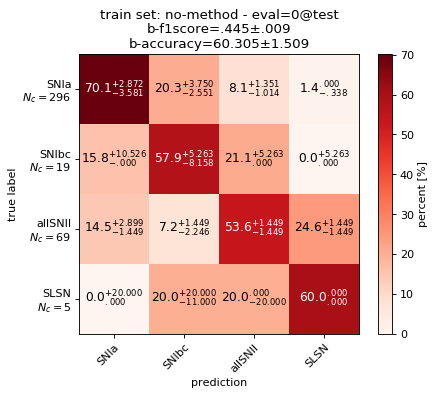

100%|██████████| 50/50 [07:19,  8.79s/it, training id: 49 - samples: 37248 - features: 18 ['SF_ML_amplitude_g', 'IAR_phi_g', 'LinearTrend_g', 'SPM_t0_g', 'SPM_gamma_g', 'SPM_beta_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g', 'MHPS_low_g', 'SF_ML_amplitude_r', 'IAR_phi_r', 'LinearTrend_r', 'SPM_t0_r', 'SPM_gamma_r', 'SPM_beta_r', 'SPM_tau_rise_r', 'SPM_tau_fall_r', 'MHPS_low_r']]


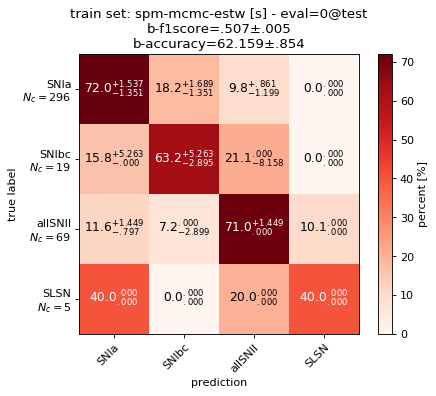

100%|██████████| 50/50 [07:29,  8.99s/it, training id: 49 - samples: 38412 - features: 18 ['SF_ML_amplitude_g', 'IAR_phi_g', 'LinearTrend_g', 'SPM_t0_g', 'SPM_gamma_g', 'SPM_beta_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g', 'MHPS_low_g', 'SF_ML_amplitude_r', 'IAR_phi_r', 'LinearTrend_r', 'SPM_t0_r', 'SPM_gamma_r', 'SPM_beta_r', 'SPM_tau_rise_r', 'SPM_tau_fall_r', 'MHPS_low_r']]


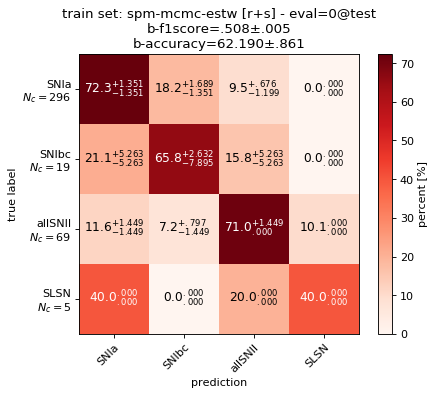

In [44]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_
from lcfats.classifiers import train_classifiers
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
from flamingchoripan.datascience.statistics import XError
import matplotlib.pyplot as plt

kf = 0
max_model_ids = 50
test_lcset_name = 'test' # val test
methods = ['bspline-fstw', 'linear-fstw', 'spm-mle-fstw', 'spm-mcmc-fstw', 'spm-mle-estw', 'spm-mcmc-estw']
#methods = ['bspline-fstw', 'linear-fstw', 'spm-mle-fstw']
#methods = ['linear-fstw']
methods = ['bspline-fstw', 'linear-fstw', 'spm-mcmc-fstw', 'spm-mcmc-estw']
#methods = ['bspline-fstw']
methods = ['spm-mcmc-estw']
for method in methods:
    new_cfilename = f'{cfilename}°method={method}'
    filedir = f'{root_folder}/{new_cfilename}.{C_.EXT_SPLIT_LIGHTCURVE}'
    lcdataset = load_pickle(filedir)
    #print(lcdataset);assert 0
    train_configs = [
        'r',
        's',
        'r+s',
        #'r-s',
    ]
    for train_config in train_configs:
        load_rootdir = f'../save/{survey}/{new_cfilename}'
        fit_kwargs = {
            'max_model_ids':max_model_ids,
            'kf':kf,
        }
        train_lcset_name = f'{method} [{train_config}]'
        results_dict, model_ids = train_classifiers(lcdataset, method, train_config, test_lcset_name, load_rootdir, **fit_kwargs)
        
        if not train_config=='r-s':
            ### plot cms
            d = results_dict
            lcset_name = d[model_ids[0]]['test_lcset_name']
            class_names = d[model_ids[0]]['class_names']
            cms = [d[id]['cm'][None] for id in model_ids]
            f1score_xe = XError([d[id]['metrics_dict']['b-f1score'] for id in model_ids])
            accuracy_xe = XError([d[id]['metrics_dict']['b-accuracy'] for id in model_ids])
            title = f'train set: {"no-method" if train_config=="r" else train_lcset_name}'
            title += f' - eval={kf}@{lcset_name}\n'
            title += f'b-f1score={f1score_xe}\n'
            title += f'b-accuracy={accuracy_xe}'
            cm_kwargs = {
                'title':title,
                'figsize':(6,5),
                'new_order_classes':['SNIa', 'SNIbc', 'allSNII', 'SLSN'],
            }
            fig, ax = plot_custom_confusion_matrix(np.concatenate(cms, axis=0), class_names, **cm_kwargs)
            plt.show()
    
        for id in results_dict.keys():
            save_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config={train_config}°eval={test_lcset_name}/id={id}.res'
            save_pickle(save_filedir, results_dict[id], verbose=0) # save
            

In [45]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.statistics import XError
from flamingchoripan.latex.latex_tables import LatexTable
import pandas as pd

test_lcset_name = 'test' # val test
methods = ['bspline-fstw', 'linear-fstw', 'spm-mle-fstw', 'spm-mcmc-fstw', 'spm-mle-estw', 'spm-mcmc-estw']
methods = ['bspline-fstw', 'linear-fstw', 'spm-mcmc-fstw', 'spm-mcmc-estw']
#methods = ['bspline-fstw', 'linear-fstw', 'spm-mle-fstw']
#methods = ['linear-fstw', 'spm-mle-fstw']

n_decimals = 3
info_dict = {}
for km,method in enumerate(methods):
    new_cfilename = f'{cfilename}°method={method}'
    metrics = [
        'b-accuracy',
        'b-f1score',
        'b-gmean',
        #'b-dpower',
        'b-xentropy',
    ]
    for metric in metrics:
        ### real
        try:
            info_dict[f'metric={metric} [real]']
        except:
            info_dict[f'metric={metric} [real]'] = {}
        for id in range(0, max_model_ids):
            load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config=r°eval={test_lcset_name}/id={id}.res'
            rf_results = load_pickle(load_filedir, verbose=0)
            v = rf_results['metrics_dict'][metric]
            try:
                info_dict[f'metric={metric} [real]'][method].append(v)
            except KeyError:
                info_dict[f'metric={metric} [real]'][method] = [v]
        
        ### synth
        try:
            info_dict[f'metric={metric} [synth]']
        except:
            info_dict[f'metric={metric} [synth]'] = {}
        for id in range(0, max_model_ids):
            load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config=s°eval={test_lcset_name}/id={id}.res'
            rf_results = load_pickle(load_filedir, verbose=0)
            v = rf_results['metrics_dict'][metric]
            try:
                info_dict[f'metric={metric} [synth]'][method].append(v)
            except KeyError:
                info_dict[f'metric={metric} [synth]'][method] = [v]
        
        ### real+synth
        try:
            info_dict[f'metric={metric} [real+synth]']
        except:
            info_dict[f'metric={metric} [real+synth]'] = {}
        for id in range(0, max_model_ids):
            load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config=r+s°eval={test_lcset_name}/id={id}.res'
            rf_results = load_pickle(load_filedir, verbose=0)
            v = rf_results['metrics_dict'][metric]
            try:
                info_dict[f'metric={metric} [real+synth]'][method].append(v)
            except KeyError:
                info_dict[f'metric={metric} [real+synth]'][method] = [v]
        
    continue
    ### real-recall
    metrics = [
        'real-recall',
        'real-xentropy',
    ]
    for metric in metrics:
        try:
            info_dict[f'metric={metric}']
        except KeyError:
            info_dict[f'metric={metric}'] = {}
        for id in range(0, max_model_ids):
            load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config=r-s°eval={test_lcset_name}/id={id}.res'
            rf_results = load_pickle(load_filedir, verbose=0)
            v = rf_results[metric]
            try:
                info_dict[f'metric={metric}'][method].append(v)
            except KeyError:
                info_dict[f'metric={metric}'][method] = [v]
    
info_df = pd.DataFrame.from_dict(info_dict, orient='index').reindex(list(info_dict.keys()))
for c in info_df.columns:
    info_df[c].values[:] = [XError(v) if isinstance(v, list) else v for v in info_df[c].values[:]] # make xerror from list

latex_kwargs = {
    'caption':f'eval: {test_lcset_name}',
    'label':'?',
    #'bold_criteriums':'max',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    #'custom_tabular_align':'l|cc|cc|cc',
    'hline_k':2,
}
latex_table = LatexTable(info_df, **latex_kwargs)
print(latex_table)
print('% \multicolumn{3}{c|}{}')
info_df

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{eval: test}
\label{?}\vspace{.1cm}
\begin{tabular}{l|ccc|c}
\hline
metric & bspline-fstw & linear-fstw & spm-mcmc-fstw & spm-mcmc-estw \srule\\\hline\hline
b-accuracy [real] & 60.592$\pm$1.342 & 60.298$\pm$1.096 & 60.324$\pm$1.384 & 60.305$\pm$1.509  \srule\\
b-accuracy [synth] & 54.818$\pm$.854 & 58.379$\pm$.826 & 60.531$\pm$1.137 & 62.159$\pm$.854  \srule\\
b-accuracy [real+synth] & 55.612$\pm$1.095 & 59.032$\pm$.999 & 60.817$\pm$1.537 & 62.190$\pm$.861  \srule\\
\hline
b-f1score [real] & .446$\pm$.009 & .444$\pm$.008 & .445$\pm$.008 & .445$\pm$.009  \srule\\
b-f1score [synth] & .467$\pm$.007 & .533$\pm$.005 & .523$\pm$.006 & .507$\pm$.005  \srule\\
b-f1score [real+synth] & .476$\pm$.008 & .539$\pm$.008 & .528$\pm$.008 & .508$\pm$.005  \srule\\
\hline
b-gmean [real] & .728$\pm$.010 & .726$\pm$.008 & .7

,bspline-fstw,linear-fstw,spm-mcmc-fstw,spm-mcmc-estw
metric=b-accuracy [real],60.592±1.342,60.298±1.096,60.324±1.384,60.305±1.509
metric=b-accuracy [synth],54.818±.854,58.379±.826,60.531±1.137,62.159±.854
metric=b-accuracy [real+synth],55.612±1.095,59.032±.999,60.817±1.537,62.190±.861
metric=b-f1score [real],.446±.009,.444±.008,.445±.008,.445±.009
metric=b-f1score [synth],.467±.007,.533±.005,.523±.006,.507±.005
metric=b-f1score [real+synth],.476±.008,.539±.008,.528±.008,.508±.005
metric=b-gmean [real],.728±.010,.726±.008,.726±.010,.726±.011
metric=b-gmean [synth],.673±.009,.712±.007,.730±.008,.738±.006
metric=b-gmean [real+synth],.680±.011,.717±.008,.732±.011,.738±.005
metric=b-xentropy [real],1.120±.010,1.120±.012,1.119±.010,1.121±.010


In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.statistics import XError
from flamingchoripan.latex.latex_tables import LatexTable
import pandas as pd

methods = ['bspline-fstw', 'linear-fstw', 'spm-mcmc-fstw', 'spm-mcmc-estw']
#methods = ['spm-mcmc-estw']

train_config = 'r'
test_lcset_name = 'test'
features_used = 15
info_dict = {f'feature-rank={k+1}':{} for k in range(0, features_used)}
for km,method in enumerate(methods):
    new_cfilename = f'{cfilename}°method={method}'
    load_filedir = f'../save/results/{survey}/{new_cfilename}/{kf}@train_config={train_config}°eval={test_lcset_name}/id=0.res'
    rf_results = load_pickle(load_filedir)
    rank = rf_results['rank']
    rank.print_n = features_used
    for k in range(0, features_used):
        f_name = rank.names[rank.idxs[k]].replace('_', '-')
        f_v = rank.values[rank.idxs[k]]*100
        info_dict[f'feature-rank={k+1}'][method] = f'{f_name} {f_v:.2f} [%]'
            
info_df = pd.DataFrame.from_dict(info_dict, orient='index').reindex(info_dict.keys())

latex_kwargs = {
    'caption':f'{method}',
    'label':'???',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    #'custom_tabular_align':'l|cc|cc|cc',
}
latex_table = LatexTable(info_df, **latex_kwargs)
print(latex_table)
info_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
> loading: ../save/results/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=bspline-fstw/0@train_config=r°eval=test/id=0.res
> loading: ../save/results/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=linear-fstw/0@train_config=r°eval=test/id=0.res
> loading: ../save/results/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-fstw/0@train_config=r°eval=test/id=0.res
> loading: ../save/results/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=spm-mcmc-estw/0@train_config=r°eval=test/id=0.res
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{spm-mcmc-estw}
\label{???}\vspace{.1cm}
\begin{tabular}{l|ccc|c}
\hline
feature-rank & bspline-fstw & linear-fstw & spm-mcmc-fstw & spm-mcmc-estw \srule\\\hline\hline

,bspline-fstw,linear-fstw,spm-mcmc-fstw,spm-mcmc-estw
feature-rank=1,SPM-tau-rise-r 14.77 [%],SPM-tau-rise-r 14.89 [%],SPM-tau-rise-r 15.49 [%],SPM-tau-rise-r 15.87 [%]
feature-rank=2,SPM-gamma-r 8.41 [%],LinearTrend-g 8.57 [%],SPM-gamma-r 8.07 [%],SPM-gamma-r 8.64 [%]
feature-rank=3,LinearTrend-g 8.03 [%],SPM-gamma-r 7.95 [%],LinearTrend-g 7.83 [%],LinearTrend-g 8.26 [%]
feature-rank=4,SPM-tau-rise-g 7.79 [%],SPM-tau-rise-g 6.83 [%],SPM-gamma-g 7.45 [%],SPM-tau-rise-g 6.92 [%]
feature-rank=5,SPM-gamma-g 6.95 [%],SPM-t0-g 6.79 [%],SPM-tau-rise-g 6.94 [%],SPM-gamma-g 6.75 [%]
feature-rank=6,SPM-t0-g 6.89 [%],SPM-tau-fall-r 6.37 [%],SPM-t0-g 6.81 [%],SPM-t0-g 6.33 [%]
feature-rank=7,SPM-tau-fall-r 6.04 [%],SPM-gamma-g 6.30 [%],SPM-tau-fall-r 5.80 [%],SPM-tau-fall-r 6.20 [%]
feature-rank=8,SPM-beta-r 5.17 [%],LinearTrend-r 5.52 [%],SPM-beta-r 5.43 [%],SPM-beta-r 5.19 [%]
feature-rank=9,LinearTrend-r 4.62 [%],SPM-beta-r 4.95 [%],LinearTrend-r 4.52 [%],LinearTrend-r 5.03 [%]
feature-rank=10,SPM-t0-r 4.35 [%],SPM-t0-r 4.48 [%],IAR-phi-r 4.08 [%],SPM-t0-r 4.03 [%]
